<a href="https://colab.research.google.com/github/MattIzon/16010269_DataAnalytics/blob/main/LR/Normalised/dow(linear).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Model
Predictors:
*   day_of_week (linear ordering)



In [1]:
# Set-up
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

def normalise(df, column_list):
  # Normalises df columns in column_list returning a dictionary of column_name: (min_value, max_value) that can be used to recover the original values
  params = dict()

  for col in column_list:
    min = df[col].min()
    max = df[col].max()
    params[col] = (min, max)
    df[col] = (df[col] - min) / (max - min)

  return params


def normalise_w_params(df, params, column_list):
  # Normalises df columns using the provided params
  for col in column_list:
    min = params[col][0]
    max = params[col][1]
    df[col] = (df[col] - min) / (max - min)


def denormalise(df, params, column_list):
  # Uses the params dictionary produced during normalisation and a list of columns to recover their original values
  for col in column_list:
    min = params[col][0]
    max = params[col][1]
    df[col] = (df[col] * (max-min)) + min


def flat_list(nested_list):
  return [value for sublist in nested_list for value in sublist]

In [2]:
generic = pd.read_csv('https://raw.githubusercontent.com/MattIzon/16010269_DataAnalytics/main/LR/All_Normalised_Whole/generic_set.csv')

Model Specific Code goes here

In [3]:
# Re-allocate day_of_week categories to produce a linear relationship
print(generic.groupby('day_of_week').mean()['crime_count'].sort_values()) # new order

label_conversions = {1:3,
                     2:7,
                     3:5,
                     4:4,
                     5:1,
                     6:2,
                     7:6}
generic['day_of_week'].replace(label_conversions, inplace=True)

day_of_week
2    721.056911
7    721.920833
3    723.493976
4    727.085020
1    734.459016
6    738.651822
5    762.152000
Name: crime_count, dtype: float64


In [4]:
columns = ['day_of_week', 'crime_count']
data = generic[columns]
scale_params = normalise(data, columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# Seperate train / eval predictors / targets
qty_predictors = 1
qty_targets = 1
train_size = int(len(data)*0.8)

train_predictors = data.iloc[:train_size,0:qty_predictors]
train_targets = data.iloc[:train_size,qty_predictors]

eval_predictors = data.iloc[train_size:,0:qty_predictors]
eval_targets = data.iloc[train_size:,qty_predictors]

In [6]:
# Design model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(qty_targets, input_shape=[qty_predictors]))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

In [7]:
# View model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train model
history = model.fit(train_predictors, train_targets, epochs=250)

Epoch 1/250
44/44 [==============================] - 1s 2ms/step - loss: 0.0954
Epoch 2/250
44/44 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 3/250
44/44 [==============================] - 0s 1ms/step - loss: 0.0408
Epoch 4/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0368
Epoch 5/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 6/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 7/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0363
Epoch 8/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0359
Epoch 9/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 10/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0359
Epoch 11/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 12/250
44/44 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 13/250
44/44 [=================

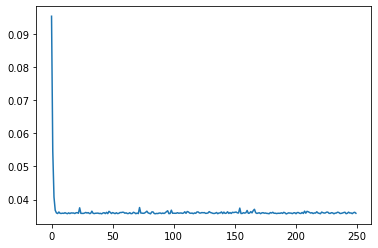

In [9]:
# View training history
plt.plot(history.history['loss'])

In [10]:
# Test model
eval_predictions = flat_list(model.predict(eval_predictors))

In [11]:
# Analyse model quality vs mean 
rmse = np.sqrt(np.mean((eval_targets.values - eval_predictions)**2))
print('LinearRegression has RMSE of {0}'.format(rmse));

avg = np.mean(train_targets)

rmse = np.sqrt(np.mean((eval_targets.values - avg)**2))
print('Using the training data mean of {0} would have has resulted in a RMSE of {1}'.format(avg, rmse));

LinearRegression has RMSE of 0.17939040193224046
Using the training data mean of 0.5156161260806462 would have has resulted in a RMSE of 0.1805106219054207


In [12]:
# Testing
test = pd.read_csv('https://raw.githubusercontent.com/MattIzon/16010269_DataAnalytics/main/LR/Normalised/test_set.csv')
test_predictors = test[columns[0:qty_predictors]]
normalise_w_params(test_predictors, scale_params, columns[0:qty_predictors])

test_predictions = pd.DataFrame(flat_list(model.predict(test_predictors)), columns=['crime_count'])
denormalise(test_predictions, scale_params, ['crime_count'])
test_targets = test[columns[qty_predictors]]

results = pd.DataFrame()
results['predicted'] = test_predictions
results['actual'] = test_targets
results['error_squared'] = (results['predicted'] - results['actual']) ** 2
print(results)

print('The RMSE on the 5 test values is {}.'.format(np.sqrt(np.mean(results.error_squared))))
print()

    predicted  actual  error_squared
0  722.456360     726      12.557385
1  746.195312     626   14446.913147
2  734.325867     732       5.409656
3  722.456360     735     157.342908
4  740.260559     794    2887.927510
The RMSE on the 5 test values is 59.177952999996734.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
